In [1]:
import operator
from typing import Annotated, TypedDict

from IPython.display import Image
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph

In [2]:
tool = TavilySearchResults(max_results=4)
type(tool), tool.name

(langchain_community.tools.tavily_search.tool.TavilySearchResults,
 'tavily_search_results_json')

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t["name"] in self.tools:
                print("\n Unknown tool name...")
                result = "Unknown tool name, please retry."
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
            )
        print("Back to the model.")
        return {"messages": results}

In [5]:
prompt = """
    You are a smart research assistant. Use the search engine to look up information.
    You are allowed to make multiple calls (either together or in sequence).
    Only look up information when you are sure of what you want.
    If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
agent = Agent(model, [tool], system=prompt)

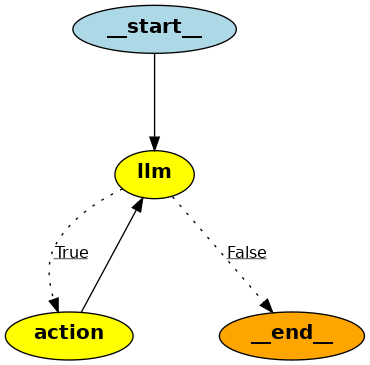

In [6]:
Image(agent.graph.get_graph().draw_png())

In [7]:
messages = [HumanMessage(content="What is the weather in Berlin?")]
result = agent.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Berlin'}, 'id': 'b3c46043-4288-4f0c-ba99-8e2d4b65dc66', 'type': 'tool_call'}
Back to the model.


In [8]:
result["messages"][-1].content

'The weather in Berlin is partly cloudy with a temperature of 16.3°C. The wind is blowing from the northwest at 9.7 km/h.  The humidity is 77%.'

In [9]:
query = """
    What is the name of the latest Gemini model?
    When it was released?
    Answer each question.
"""
messages = [HumanMessage(content=query)]

In [10]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
agent = Agent(model, [tool], system=prompt)
result = agent.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What is the name of the latest Gemini model?'}, 'id': '1fc93f35-532d-41bd-b1e0-e3ae22f2a0a9', 'type': 'tool_call'}
Back to the model.
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'When was Gemini 2.0 Flash released?'}, 'id': '9dba228c-155a-43c0-a57d-777488c30c8e', 'type': 'tool_call'}
Back to the model.


In [11]:
result["messages"][-1].content

'The latest Gemini model is Gemini 2.0 Flash. It was released on January 30, 2025.'